# Import library

In [15]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
pd.set_option("display.max_column", 100)

In [17]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

In [18]:
dir_result = "../mc_scripts/model/train_result/"

all_results = dict()
result_dirs = sorted(os.listdir(dir_result))
display(result_dirs)
for train_name in result_dirs:
    
    if not os.path.isdir(os.path.join(dir_result, train_name)):
        continue
    
    if not 'v11' in train_name:
        continue
        
    df_result = pd.read_csv(os.path.join(dir_result, train_name, "result.csv"))
    print(train_name)
    display(df_result)
    all_results[train_name] = df_result

['.DS_Store',
 'all_manual_20230323_014415',
 'owid_manual_20230321_050601',
 'patient+loc+loc-1+loc-2+loc-3+loc-4+loc-5+loc-6+loc-7_manual_20230323_010929',
 'patient+loc_manual_20230323_002327',
 'patient_manual_20230321_050609',
 'patient_manual_20230322_212408',
 'si3_manual_20230321_050605',
 'v10_patient_testmonthvalrandom_20230327_012748',
 'v10_patient_testmonthvalrandom_20230327_012810',
 'v10_patient_testmonthvalrandom_20230327_013715',
 'v10_patient_testmonthvalrandom_20230327_014846',
 'v10_patient_testmonthvalrandom_20230327_022118',
 'v10_patient_testmonthvalrandom_20230327_023343',
 'v10_patient_testmonthvalrandom_20230327_024558',
 'v10_patient_testmonthvalrandom_20230327_050747',
 'v10_patient_testmonthvalrandom_20230327_052517',
 'v10_patient_testmonthvalrandom_20230327_071354',
 'v10_patient_testmonthvalrandom_20230327_084910',
 'v10_patient_testmonthvalrandom_20230327_122900',
 'v11_all_testmonthvalrandom_20230327_180822_2022-03',
 'v11_all_testmonthvalrandom_202303

v11_all_testmonthvalrandom_20230327_180822_2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.802539,0.818019,0.820134,0.810931,0.814265,0.813177,0.005646
1,XGBoost,0.809116,0.790754,0.795099,0.798336,0.757957,0.790252,0.015748
2,LGBM,0.735395,0.819801,0.813077,0.790819,0.794124,0.790643,0.027135
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,0.083713


v11_all_testmonthvalrandom_20230327_180848_2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.896497,0.895927,0.896375,0.896279,0.895859,0.896188,0.000229
1,XGBoost,0.883052,0.881098,0.880044,0.878556,0.880046,0.880559,0.001357
2,LGBM,0.860500,0.859570,0.869747,0.866677,0.869397,0.865178,0.003964
3,TabNet,0.851258,0.877531,0.877343,0.872469,0.878421,0.871404,0.009390


v11_all_testmonthvalrandom_20230327_182339_2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.799339,0.799260,0.793939,0.796938,0.802723,0.798440,0.002656
1,XGBoost,0.783390,0.774069,0.774567,0.745097,0.789268,0.773278,0.013871
2,LGBM,0.829227,0.817278,0.817816,0.820901,0.839039,0.824852,0.007560
3,TabNet,0.775469,0.769206,0.770089,0.779071,0.766181,0.772003,0.004230


v11_all_testmonthvalrandom_20230327_184324_2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.804374,0.804545,0.797856,0.806261,0.802744,0.803156,0.002624
1,XGBoost,0.799314,0.802101,0.813551,0.788422,0.775901,0.795858,0.011673
2,LGBM,0.817238,0.817667,0.772813,0.853345,0.815094,0.815232,0.023316
3,TabNet,0.583319,0.700257,0.721655,0.604503,0.738422,0.669631,0.057833


v11_all_testmonthvalrandom_20230327_190411_2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.827760,0.829730,0.828307,0.828718,0.830004,0.828904,0.000774
1,XGBoost,0.820193,0.816964,0.810820,0.817826,0.816800,0.816521,0.002827
2,LGBM,0.823436,0.841142,0.843851,0.838214,0.843906,0.838110,0.006965
3,TabNet,0.785617,0.769197,0.823600,0.791582,0.798834,0.793766,0.016282


v11_all_testmonthvalrandom_20230327_192320_2022-08


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.764793,0.760323,0.762365,0.761507,0.763655,0.762529,0.001434
1,XGBoost,0.749922,0.740716,0.746795,0.753125,0.750556,0.748223,0.003889
2,LGBM,0.805722,0.797848,0.803169,0.808576,0.805282,0.804119,0.003266
3,TabNet,0.745095,0.768561,0.767021,0.756988,0.747334,0.757000,0.008843


v11_all_testmonthvalrandom_20230327_194302_2022-09


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.787332,0.791005,0.784554,0.785778,0.785613,0.786857,0.002060
1,XGBoost,0.775700,0.773087,0.779126,0.777608,0.779739,0.777052,0.002213
2,LGBM,0.815517,0.825194,0.807205,0.812244,0.812903,0.814613,0.005419
3,TabNet,0.784601,0.787179,0.801319,0.809206,0.799447,0.796350,0.008384


v11_all_testmonthvalrandom_20230327_200415_2022-10


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.740150,0.740033,0.747127,0.737453,0.738333,0.740619,0.003114
1,XGBoost,0.710454,0.710542,0.702656,0.750821,0.737248,0.722344,0.016839
2,LGBM,0.782129,0.736632,0.771869,0.757622,0.806637,0.770978,0.021427
3,TabNet,0.761931,0.774244,0.710894,0.746306,0.723323,0.743340,0.021459


v11_all_testmonthvalrandom_20230327_202735_2022-11


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.737909,0.733850,0.732383,0.733117,0.733361,0.734124,0.001781
1,XGBoost,0.721038,0.725097,0.715756,0.701269,0.721612,0.716954,0.007661
2,LGBM,0.757910,0.769842,0.763729,0.782263,0.754438,0.765636,0.008971
3,TabNet,0.728569,0.743447,0.764182,0.712517,0.755110,0.740765,0.016872


v11_all_testmonthvalrandom_20230327_204924_2022-12


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.708965,0.738883,0.739031,0.740383,0.738525,0.733157,0.011057
1,XGBoost,0.739285,0.753030,0.742768,0.740319,0.756598,0.746400,0.006439
2,LGBM,0.777290,0.781491,0.796377,0.806533,0.801655,0.792669,0.010394
3,TabNet,0.679796,0.706547,0.718435,0.665132,0.741354,0.702253,0.024804


v11_all_testmonthvalrandom_20230327_211425_2023-01


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.767329,0.766004,0.770916,0.768187,0.761014,0.766690,0.002978
1,XGBoost,0.801014,0.806160,0.792281,0.803353,0.817232,0.804008,0.007376
2,LGBM,0.796101,0.801481,0.829396,0.820039,0.812086,0.811821,0.011034
3,TabNet,0.729513,0.795750,0.754230,0.674776,0.799181,0.750690,0.042043


v11_all_testmonthvalrandom_20230327_213946_2023-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.729079,0.707706,0.748344,0.736604,0.736303,0.731607,0.012280
1,XGBoost,0.718242,0.710415,0.705750,0.650060,0.626430,0.682179,0.033648
2,LGBM,0.705298,0.688441,0.672185,0.673691,0.726972,0.693317,0.018849
3,TabNet,0.712372,0.779199,0.660747,0.608218,0.613185,0.674744,0.058791


v11_patient_testmonthvalrandom_20230327_140012_2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.836192,0.835473,0.832963,0.834374,0.832698,0.834340,0.001246
1,XGBoost,0.835396,0.837844,0.835223,0.830377,0.836731,0.835114,0.002331
2,LGBM,0.785939,0.803770,0.796650,0.798299,0.793973,0.795726,0.005339
3,TabNet,0.488531,0.590363,0.419127,0.732859,0.781013,0.602379,0.126242


v11_patient_testmonthvalrandom_20230327_140026_2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.867952,0.866929,0.867115,0.867553,0.868574,0.867625,0.000541
1,XGBoost,0.865335,0.865968,0.865562,0.866123,0.866680,0.865934,0.000426
2,LGBM,0.866430,0.862384,0.867025,0.869022,0.867747,0.866522,0.002047
3,TabNet,0.864420,0.866096,0.863246,0.860416,0.861707,0.863177,0.001819


v11_patient_testmonthvalrandom_20230327_140901_2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.773240,0.772032,0.771833,0.772669,0.772417,0.772439,0.000452
1,XGBoost,0.772351,0.773844,0.771528,0.771926,0.773804,0.772691,0.000877
2,LGBM,0.792234,0.786495,0.790031,0.785221,0.792877,0.789372,0.002781
3,TabNet,0.774248,0.774474,0.785314,0.782402,0.777632,0.778814,0.004004


v11_patient_testmonthvalrandom_20230327_141951_2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.815523,0.812436,0.810034,0.812864,0.809777,0.812127,0.001918
1,XGBoost,0.811750,0.811664,0.811578,0.811578,0.811407,0.811595,0.000104
2,LGBM,0.855660,0.855189,0.850129,0.854846,0.849142,0.852993,0.002530
3,TabNet,0.854245,0.861106,0.824871,0.859648,0.823413,0.844657,0.015438


v11_patient_testmonthvalrandom_20230327_143500_2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.839021,0.839678,0.837954,0.837543,0.839048,0.838649,0.000714
1,XGBoost,0.842551,0.842305,0.842305,0.842551,0.842469,0.842436,0.000102
2,LGBM,0.844357,0.836886,0.839787,0.839554,0.841032,0.840323,0.002216
3,TabNet,0.832029,0.831783,0.831331,0.832809,0.826433,0.830877,0.002075


v11_patient_testmonthvalrandom_20230327_144857_2022-08


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.788286,0.789660,0.788665,0.787960,0.789500,0.788814,0.000608
1,XGBoost,0.783011,0.783736,0.783546,0.783008,0.782772,0.783215,0.000332
2,LGBM,0.799419,0.795890,0.804614,0.800520,0.799852,0.800059,0.002543
3,TabNet,0.785478,0.799488,0.796979,0.802155,0.797507,0.796321,0.005220


v11_patient_testmonthvalrandom_20230327_150211_2022-09


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.790499,0.791158,0.790217,0.789675,0.789581,0.790226,0.000527
1,XGBoost,0.779338,0.779856,0.778832,0.779903,0.779762,0.779538,0.000370
2,LGBM,0.829833,0.830162,0.828032,0.828055,0.830198,0.829256,0.000911
3,TabNet,0.812515,0.800153,0.801825,0.812421,0.817389,0.808860,0.006111


v11_patient_testmonthvalrandom_20230327_151740_2022-10


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.757153,0.752873,0.755218,0.754397,0.752814,0.754491,0.001475
1,XGBoost,0.738948,0.739564,0.739065,0.739505,0.739329,0.739282,0.000220
2,LGBM,0.765977,0.765068,0.766211,0.766534,0.762019,0.765162,0.001502
3,TabNet,0.753870,0.749296,0.742554,0.743873,0.749326,0.747784,0.003749


v11_patient_testmonthvalrandom_20230327_153615_2022-11


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.757580,0.756162,0.756651,0.757922,0.757678,0.757198,0.000616
1,XGBoost,0.751174,0.750672,0.750746,0.751198,0.750782,0.750914,0.000205
2,LGBM,0.813573,0.789867,0.795944,0.783474,0.800614,0.796694,0.009329
3,TabNet,0.783388,0.771761,0.774439,0.781151,0.793670,0.780882,0.007007


v11_patient_testmonthvalrandom_20230327_155243_2022-12


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.760578,0.760388,0.759734,0.759734,0.759037,0.759894,0.000500
1,XGBoost,0.747181,0.746157,0.747688,0.747202,0.746073,0.746860,0.000580
2,LGBM,0.783265,0.783846,0.788491,0.779739,0.787805,0.784629,0.002926
3,TabNet,0.773373,0.760071,0.760758,0.764695,0.762953,0.764370,0.004372


v11_patient_testmonthvalrandom_20230327_171931_2023-01


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.792320,0.794035,0.793723,0.792865,0.791696,0.792928,0.000791
1,XGBoost,0.777895,0.778051,0.778596,0.777739,0.778207,0.778097,0.000269
2,LGBM,0.791657,0.797856,0.789825,0.786121,0.789474,0.790986,0.003534
3,TabNet,0.788577,0.781404,0.779454,0.776608,0.783470,0.781903,0.003681


v11_patient_testmonthvalrandom_20230327_174401_2023-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.684828,0.684828,0.682721,0.685731,0.685731,0.684768,0.001004
1,XGBoost,0.656081,0.655930,0.655328,0.655629,0.656833,0.655960,0.000463
2,LGBM,0.759332,0.741571,0.759482,0.768061,0.757676,0.757225,0.007876
3,TabNet,0.718844,0.722155,0.692053,0.697321,0.684828,0.703040,0.013542


v11_si3_testmonthvalrandom_20230331_041051_2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.529653,0.528293,0.528678,0.529689,0.528527,0.528968,0.000536
1,XGBoost,0.505899,0.502483,0.525574,0.506926,0.504172,0.509011,0.007685
2,LGBM,0.526833,0.498037,0.497004,0.511787,0.526283,0.511989,0.011860
3,TabNet,0.501021,0.469840,0.474375,0.484525,0.472068,0.480366,0.010484


v11_si3_testmonthvalrandom_20230331_041111_2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.676488,0.674675,0.674559,0.675232,0.675498,0.675290,0.000632
1,XGBoost,0.634533,0.631680,0.632035,0.631698,0.629914,0.631972,0.001352
2,LGBM,0.606780,0.587089,0.612043,0.608710,0.589960,0.600916,0.009400
3,TabNet,0.641727,0.629805,0.656010,0.612005,0.628979,0.633705,0.013356


v11_si3_testmonthvalrandom_20230331_042229_2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.561911,0.560133,0.556471,0.559350,0.560239,0.559621,0.001627
1,XGBoost,0.536263,0.537371,0.542645,0.589311,0.541026,0.549323,0.018375
2,LGBM,0.593756,0.568904,0.536781,0.604072,0.570403,0.574783,0.021275
3,TabNet,0.544005,0.624957,0.524441,0.612007,0.569713,0.575025,0.035143


v11_si3_testmonthvalrandom_20230331_043859_2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.513765,0.508877,0.517281,0.513593,0.519340,0.514571,0.003269
1,XGBoost,0.510120,0.519768,0.502230,0.511021,0.522427,0.513113,0.006618
2,LGBM,0.515137,0.543525,0.549828,0.538979,0.522341,0.533962,0.011957
3,TabNet,0.496226,0.482290,0.515823,0.515309,0.459777,0.493885,0.019337


v11_si3_testmonthvalrandom_20230331_045254_2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.552145,0.554526,0.553131,0.553185,0.553842,0.553366,0.000725
1,XGBoost,0.495704,0.502668,0.497250,0.499521,0.489875,0.497003,0.003894
2,LGBM,0.537833,0.540761,0.537628,0.558576,0.528036,0.540567,0.009106
3,TabNet,0.523411,0.522399,0.522016,0.498591,0.543689,0.522021,0.013042


v11_si3_testmonthvalrandom_20230331_050501_2022-08


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.500159,0.499575,0.502899,0.499150,0.502960,0.500949,0.001505
1,XGBoost,0.505772,0.508139,0.509813,0.508158,0.506595,0.507696,0.001278
2,LGBM,0.498330,0.491341,0.512978,0.493272,0.500262,0.499237,0.006936
3,TabNet,0.490779,0.488662,0.509638,0.474845,0.496042,0.491993,0.010282


v11_si3_testmonthvalrandom_20230331_051703_2022-09


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.553238,0.558700,0.556864,0.555451,0.555263,0.555903,0.001657
1,XGBoost,0.529126,0.536461,0.531481,0.526878,0.521698,0.529129,0.004464
2,LGBM,0.516682,0.525077,0.516153,0.514328,0.519002,0.518248,0.003401
3,TabNet,0.517083,0.519308,0.519920,0.501884,0.559654,0.523570,0.017540


v11_si3_testmonthvalrandom_20230331_053523_2022-10


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.616469,0.617525,0.608671,0.613479,0.617056,0.614640,0.003013
1,XGBoost,0.574959,0.550891,0.523775,0.589294,0.568275,0.561439,0.020556
2,LGBM,0.492407,0.459780,0.563321,0.501114,0.479597,0.499244,0.031884
3,TabNet,0.504075,0.527117,0.566399,0.492671,0.511697,0.520392,0.023353


v11_si3_testmonthvalrandom_20230331_055144_2022-11


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.495415,0.482725,0.487640,0.492481,0.490012,0.489655,0.003945
1,XGBoost,0.435535,0.437491,0.467040,0.460634,0.451697,0.450479,0.011335
2,LGBM,0.497665,0.508876,0.491039,0.512580,0.485464,0.499125,0.009401
3,TabNet,0.502164,0.512054,0.480207,0.452553,0.476661,0.484728,0.019024


v11_si3_testmonthvalrandom_20230331_060447_2022-12


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.529887,0.521357,0.539557,0.534574,0.529971,0.531069,0.005496
1,XGBoost,0.452409,0.445156,0.480290,0.460464,0.475413,0.462747,0.012177
2,LGBM,0.529084,0.502059,0.519963,0.549438,0.551096,0.530328,0.016855
3,TabNet,0.483373,0.510409,0.469986,0.471401,0.598264,0.506687,0.043848


v11_si3_testmonthvalrandom_20230331_061936_2023-01


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.512904,0.513684,0.502612,0.506121,0.507290,0.508522,0.003831
1,XGBoost,0.568265,0.569903,0.566511,0.576803,0.561287,0.568554,0.004600
2,LGBM,0.553372,0.620078,0.594776,0.605341,0.534386,0.581591,0.029563
3,TabNet,0.553528,0.583353,0.593138,0.628928,0.615595,0.594908,0.023924


v11_si3_testmonthvalrandom_20230331_063344_2023-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.562914,0.565322,0.569837,0.569235,0.569235,0.567309,0.002486
1,XGBoost,0.448675,0.476370,0.460566,0.459061,0.499398,0.468814,0.016131
2,LGBM,0.583685,0.550873,0.514148,0.472908,0.554786,0.535280,0.034889
3,TabNet,0.489765,0.651114,0.706201,0.595123,0.578567,0.604154,0.066383


v11_si6_testmonthvalrandom_20230328_200928_2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.529381,0.528293,0.530144,0.529674,0.527340,0.528966,0.000927
1,XGBoost,0.482303,0.500000,0.482472,0.500000,0.492478,0.491450,0.007206
2,LGBM,0.526833,0.498037,0.497004,0.511787,0.526283,0.511989,0.011860
3,TabNet,0.522871,0.491839,0.488704,0.528199,0.492208,0.504764,0.015598


v11_si6_testmonthvalrandom_20230328_200949_2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.673653,0.675073,0.670882,0.672032,0.670602,0.672448,0.001548
1,XGBoost,0.630863,0.630665,0.629609,0.629328,0.625521,0.629197,0.001762
2,LGBM,0.605823,0.587089,0.612043,0.608710,0.589960,0.600725,0.009307
3,TabNet,0.657326,0.659647,0.560291,0.530708,0.564309,0.594456,0.048892


v11_si6_testmonthvalrandom_20230328_202323_2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.564777,0.560372,0.553287,0.555436,0.561261,0.559027,0.003780
1,XGBoost,0.567902,0.579187,0.574331,0.595315,0.574331,0.578213,0.008464
2,LGBM,0.593756,0.556849,0.536781,0.604072,0.570403,0.572372,0.022263
3,TabNet,0.636394,0.552716,0.557526,0.576911,0.580122,0.580734,0.027193


v11_si6_testmonthvalrandom_20230328_203625_2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.511449,0.510678,0.516166,0.514280,0.516595,0.513834,0.002195
1,XGBoost,0.465995,0.471569,0.471226,0.465995,0.482461,0.471449,0.005490
2,LGBM,0.515137,0.543525,0.549828,0.538979,0.522341,0.533962,0.011957
3,TabNet,0.491724,0.517367,0.472899,0.537693,0.478516,0.499640,0.022309


v11_si6_testmonthvalrandom_20230328_205919_2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.551475,0.555689,0.553527,0.554649,0.556729,0.554414,0.001657
1,XGBoost,0.499398,0.497099,0.483799,0.480666,0.487261,0.489645,0.006723
2,LGBM,0.524465,0.508456,0.524055,0.533687,0.529076,0.523948,0.007761
3,TabNet,0.494869,0.506267,0.527256,0.559384,0.508114,0.519178,0.020663


v11_si6_testmonthvalrandom_20230328_211731_2022-08


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.499180,0.500008,0.508105,0.498110,0.507604,0.502602,0.003957
1,XGBoost,0.509236,0.515588,0.512143,0.513038,0.518628,0.513727,0.002905
2,LGBM,0.492786,0.507768,0.505859,0.504645,0.505495,0.503310,0.004893
3,TabNet,0.508037,0.501328,0.513706,0.498171,0.477585,0.499765,0.011253


v11_si6_testmonthvalrandom_20230328_213859_2022-09


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.554650,0.558818,0.558818,0.554603,0.554486,0.556275,0.001896
1,XGBoost,0.538156,0.532023,0.546786,0.532011,0.511514,0.532098,0.010616
2,LGBM,0.498658,0.512750,0.472534,0.514163,0.507888,0.501198,0.013990
3,TabNet,0.540676,0.563680,0.540723,0.551483,0.541170,0.547547,0.008269


v11_si6_testmonthvalrandom_20230328_220209_2022-10


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.606092,0.604978,0.609023,0.604743,0.618228,0.608613,0.004604
1,XGBoost,0.546171,0.524390,0.495984,0.553764,0.554116,0.534885,0.020319
2,LGBM,0.556285,0.532335,0.551477,0.513661,0.525621,0.535876,0.014555
3,TabNet,0.462799,0.486339,0.504251,0.456614,0.492056,0.480412,0.016409


v11_si6_testmonthvalrandom_20230328_222258_2022-11


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.503338,0.494829,0.504536,0.503313,0.509108,0.503025,0.004216
1,XGBoost,0.509621,0.450450,0.478239,0.503484,0.470243,0.482407,0.019881
2,LGBM,0.502934,0.529745,0.485073,0.493019,0.538620,0.509878,0.019011
3,TabNet,0.557179,0.463079,0.535613,0.551616,0.513717,0.524241,0.031132


v11_si6_testmonthvalrandom_20230328_224301_2022-12


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.515983,0.505722,0.529855,0.520797,0.516638,0.517799,0.007128
1,XGBoost,0.448007,0.448440,0.430208,0.434124,0.484460,0.449048,0.017479
2,LGBM,0.513925,0.510272,0.506028,0.542714,0.497931,0.514174,0.013904
3,TabNet,0.532695,0.509311,0.568093,0.542196,0.539473,0.538354,0.017204


v11_si6_testmonthvalrandom_20230328_230421_2023-01


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.511189,0.510253,0.486082,0.493177,0.492554,0.498651,0.009282
1,XGBoost,0.585107,0.557154,0.574035,0.558635,0.584600,0.571906,0.011058
2,LGBM,0.558441,0.616218,0.550253,0.557622,0.492398,0.554986,0.035842
3,TabNet,0.557544,0.563977,0.592398,0.529240,0.424211,0.533474,0.053132


v11_si6_testmonthvalrandom_20230328_232706_2023-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.557495,0.563215,0.560506,0.565924,0.559001,0.561228,0.002751
1,XGBoost,0.399308,0.412101,0.444913,0.438290,0.434076,0.425738,0.015702
2,LGBM,0.562613,0.533113,0.515954,0.527393,0.555689,0.538952,0.016003
3,TabNet,0.515352,0.656833,0.663305,0.760385,0.508429,0.620861,0.087878


In [19]:
df_result_all = pd.DataFrame()

for train_name, df_result in all_results.items():
    df_result = df_result.rename(columns={'Unnamed: 0': 'structure'})
    df_result['train_name'] = train_name
    df_result_all = df_result_all.append(df_result)
    print(train_name, df_result.shape, df_result_all.shape)

df_result_all

v11_all_testmonthvalrandom_20230327_180822_2022-03 (4, 9) (4, 9)
v11_all_testmonthvalrandom_20230327_180848_2022-04 (4, 9) (8, 9)
v11_all_testmonthvalrandom_20230327_182339_2022-05 (4, 9) (12, 9)
v11_all_testmonthvalrandom_20230327_184324_2022-06 (4, 9) (16, 9)
v11_all_testmonthvalrandom_20230327_190411_2022-07 (4, 9) (20, 9)
v11_all_testmonthvalrandom_20230327_192320_2022-08 (4, 9) (24, 9)
v11_all_testmonthvalrandom_20230327_194302_2022-09 (4, 9) (28, 9)
v11_all_testmonthvalrandom_20230327_200415_2022-10 (4, 9) (32, 9)
v11_all_testmonthvalrandom_20230327_202735_2022-11 (4, 9) (36, 9)
v11_all_testmonthvalrandom_20230327_204924_2022-12 (4, 9) (40, 9)
v11_all_testmonthvalrandom_20230327_211425_2023-01 (4, 9) (44, 9)
v11_all_testmonthvalrandom_20230327_213946_2023-02 (4, 9) (48, 9)
v11_patient_testmonthvalrandom_20230327_140012_2022-03 (4, 9) (52, 9)
v11_patient_testmonthvalrandom_20230327_140026_2022-04 (4, 9) (56, 9)
v11_patient_testmonthvalrandom_20230327_140901_2022-05 (4, 9) (60, 9)


/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_83924/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_83924/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_83924/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_83924/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,structure,0,1,2,3,4,mean,std,train_name
0,LR,0.802539,0.818019,0.820134,0.810931,0.814265,0.813177,0.005646,v11_all_testmonthvalrandom_20230327_180822_202...
1,XGBoost,0.809116,0.790754,0.795099,0.798336,0.757957,0.790252,0.015748,v11_all_testmonthvalrandom_20230327_180822_202...
2,LGBM,0.735395,0.819801,0.813077,0.790819,0.794124,0.790643,0.027135,v11_all_testmonthvalrandom_20230327_180822_202...
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,0.083713,v11_all_testmonthvalrandom_20230327_180822_202...
0,LR,0.896497,0.895927,0.896375,0.896279,0.895859,0.896188,0.000229,v11_all_testmonthvalrandom_20230327_180848_202...
...,...,...,...,...,...,...,...,...,...
3,TabNet,0.557544,0.563977,0.592398,0.529240,0.424211,0.533474,0.053132,v11_si6_testmonthvalrandom_20230328_230421_202...
0,LR,0.557495,0.563215,0.560506,0.565924,0.559001,0.561228,0.002751,v11_si6_testmonthvalrandom_20230328_232706_202...
1,XGBoost,0.399308,0.412101,0.444913,0.438290,0.434076,0.425738,0.015702,v11_si6_testmonthvalrandom_20230328_232706_202...
2,LGBM,0.562613,0.533113,0.515954,0.527393,0.555689,0.538952,0.016003,v11_si6_testmonthvalrandom_20230328_232706_202...


In [20]:
df_result_all['split'] = df_result_all['train_name'].apply(lambda x : x.split("_")[2])
df_result_all['features'] = df_result_all['train_name'].apply(lambda x : x.split("_")[1])
df_result_all['year_month'] = df_result_all['train_name'].apply(lambda x : x.split("_")[-1] if not x.split("_")[2] == 'manual' else None)
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.802539,0.818019,0.820134,0.810931,0.814265,0.813177,0.005646,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
1,XGBoost,0.809116,0.790754,0.795099,0.798336,0.757957,0.790252,0.015748,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
2,LGBM,0.735395,0.819801,0.813077,0.790819,0.794124,0.790643,0.027135,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,0.083713,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
0,LR,0.896497,0.895927,0.896375,0.896279,0.895859,0.896188,0.000229,v11_all_testmonthvalrandom_20230327_180848_202...,testmonthvalrandom,all,2022-04
...,...,...,...,...,...,...,...,...,...,...,...,...
3,TabNet,0.557544,0.563977,0.592398,0.529240,0.424211,0.533474,0.053132,v11_si6_testmonthvalrandom_20230328_230421_202...,testmonthvalrandom,si6,2023-01
0,LR,0.557495,0.563215,0.560506,0.565924,0.559001,0.561228,0.002751,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02
1,XGBoost,0.399308,0.412101,0.444913,0.438290,0.434076,0.425738,0.015702,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02
2,LGBM,0.562613,0.533113,0.515954,0.527393,0.555689,0.538952,0.016003,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02


In [21]:
df_result_all[df_result_all['structure'] == 'LR']

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.802539,0.818019,0.820134,0.810931,0.814265,0.813177,0.005646,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
0,LR,0.896497,0.895927,0.896375,0.896279,0.895859,0.896188,0.000229,v11_all_testmonthvalrandom_20230327_180848_202...,testmonthvalrandom,all,2022-04
0,LR,0.799339,0.799260,0.793939,0.796938,0.802723,0.798440,0.002656,v11_all_testmonthvalrandom_20230327_182339_202...,testmonthvalrandom,all,2022-05
0,LR,0.804374,0.804545,0.797856,0.806261,0.802744,0.803156,0.002624,v11_all_testmonthvalrandom_20230327_184324_202...,testmonthvalrandom,all,2022-06
0,LR,0.827760,0.829730,0.828307,0.828718,0.830004,0.828904,0.000774,v11_all_testmonthvalrandom_20230327_190411_202...,testmonthvalrandom,all,2022-07
0,LR,0.764793,0.760323,0.762365,0.761507,0.763655,0.762529,0.001434,v11_all_testmonthvalrandom_20230327_192320_202...,testmonthvalrandom,all,2022-08
0,LR,0.787332,0.791005,0.784554,0.785778,0.785613,0.786857,0.002060,v11_all_testmonthvalrandom_20230327_194302_202...,testmonthvalrandom,all,2022-09
0,LR,0.740150,0.740033,0.747127,0.737453,0.738333,0.740619,0.003114,v11_all_testmonthvalrandom_20230327_200415_202...,testmonthvalrandom,all,2022-10
0,LR,0.737909,0.733850,0.732383,0.733117,0.733361,0.734124,0.001781,v11_all_testmonthvalrandom_20230327_202735_202...,testmonthvalrandom,all,2022-11
0,LR,0.708965,0.738883,0.739031,0.740383,0.738525,0.733157,0.011057,v11_all_testmonthvalrandom_20230327_204924_202...,testmonthvalrandom,all,2022-12


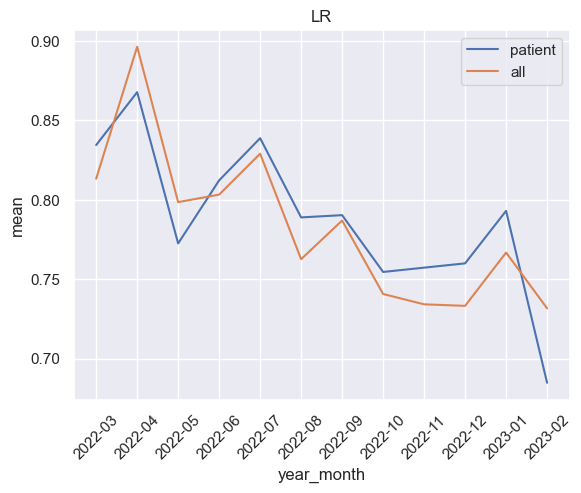

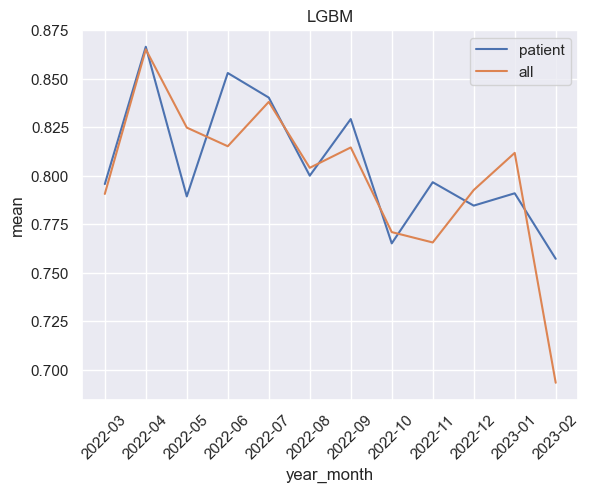

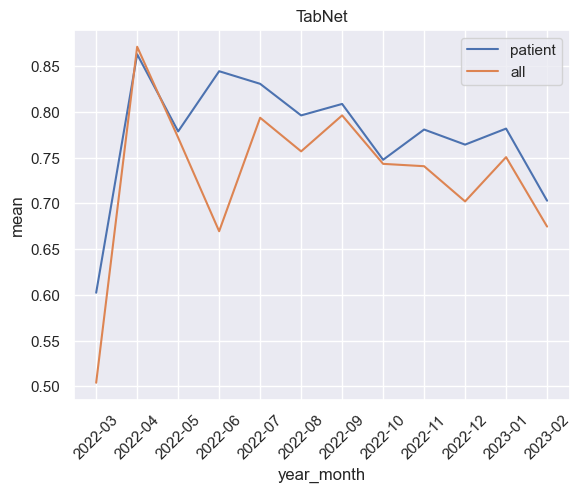

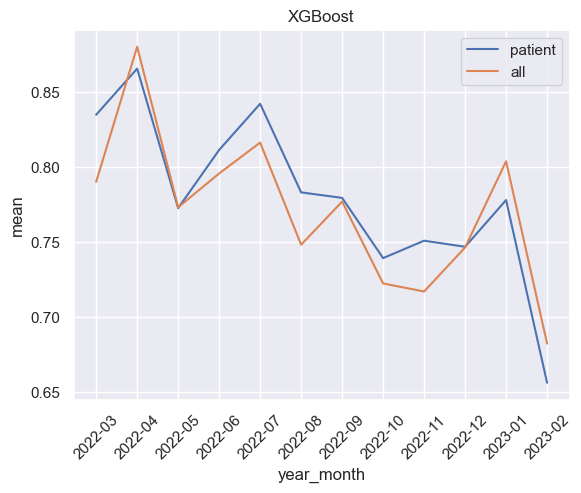

In [22]:
def plot_patient_vs_all(df_result_all, structure):
    df_lr = df_result_all[df_result_all['structure'] == structure]
    df_lr_patient = df_lr[df_lr['features'] == 'patient']
    df_lr_all = df_lr[df_lr['features'] == 'all']
    sns.lineplot(data=df_lr_patient.reset_index(drop=True), x='year_month', y='mean', label='patient')
    sns.lineplot(data=df_lr_all.reset_index(drop=True), x='year_month', y='mean', label='all')
    plt.title(structure)
    plt.xticks(rotation=45)
    plt.show()
    
plot_patient_vs_all(df_result_all, 'LR')
plot_patient_vs_all(df_result_all, 'LGBM')
plot_patient_vs_all(df_result_all, 'TabNet')
plot_patient_vs_all(df_result_all, 'XGBoost')

In [23]:
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.802539,0.818019,0.820134,0.810931,0.814265,0.813177,0.005646,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
1,XGBoost,0.809116,0.790754,0.795099,0.798336,0.757957,0.790252,0.015748,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
2,LGBM,0.735395,0.819801,0.813077,0.790819,0.794124,0.790643,0.027135,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,0.083713,v11_all_testmonthvalrandom_20230327_180822_202...,testmonthvalrandom,all,2022-03
0,LR,0.896497,0.895927,0.896375,0.896279,0.895859,0.896188,0.000229,v11_all_testmonthvalrandom_20230327_180848_202...,testmonthvalrandom,all,2022-04
...,...,...,...,...,...,...,...,...,...,...,...,...
3,TabNet,0.557544,0.563977,0.592398,0.529240,0.424211,0.533474,0.053132,v11_si6_testmonthvalrandom_20230328_230421_202...,testmonthvalrandom,si6,2023-01
0,LR,0.557495,0.563215,0.560506,0.565924,0.559001,0.561228,0.002751,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02
1,XGBoost,0.399308,0.412101,0.444913,0.438290,0.434076,0.425738,0.015702,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02
2,LGBM,0.562613,0.533113,0.515954,0.527393,0.555689,0.538952,0.016003,v11_si6_testmonthvalrandom_20230328_232706_202...,testmonthvalrandom,si6,2023-02


In [24]:

def reformat_target_table(df_result_all):
    # Reformat table
    df = df_result_all.copy()
    dfs = []
    for i in range(len(df)):
        row = df.iloc[i]
        row_dict = {'structure': row['structure'], 'mean': row['mean'], 'std': row['std'], 'train_name': row['train_name'], 'split': row['split'], 'features': row['features'], 'year_month': row['year_month']}
        for j in range(5):
            row_dict['fold'] = j
            row_dict['score'] = row[str(j)]
            dfs.append(pd.DataFrame([row_dict]))

    # concatenate the list of dataframes into the regularized table
    df_new = pd.concat(dfs, ignore_index=True)

    # print the regularized tab
    # print the regularized table
    return df_new[['structure', 'year_month', 'fold', 'split', 'features', 'score', 'train_name']]
df_result_all_new = reformat_target_table(df_result_all)
df_result_all_new

,structure,year_month,fold,split,features,score,train_name
0,LR,2022-03,0,testmonthvalrandom,all,0.802539,v11_all_testmonthvalrandom_20230327_180822_202...
1,LR,2022-03,1,testmonthvalrandom,all,0.818019,v11_all_testmonthvalrandom_20230327_180822_202...
2,LR,2022-03,2,testmonthvalrandom,all,0.820134,v11_all_testmonthvalrandom_20230327_180822_202...
3,LR,2022-03,3,testmonthvalrandom,all,0.810931,v11_all_testmonthvalrandom_20230327_180822_202...
4,LR,2022-03,4,testmonthvalrandom,all,0.814265,v11_all_testmonthvalrandom_20230327_180822_202...
...,...,...,...,...,...,...,...
955,TabNet,2023-02,0,testmonthvalrandom,si6,0.515352,v11_si6_testmonthvalrandom_20230328_232706_202...
956,TabNet,2023-02,1,testmonthvalrandom,si6,0.656833,v11_si6_testmonthvalrandom_20230328_232706_202...
957,TabNet,2023-02,2,testmonthvalrandom,si6,0.663305,v11_si6_testmonthvalrandom_20230328_232706_202...
958,TabNet,2023-02,3,testmonthvalrandom,si6,0.760385,v11_si6_testmonthvalrandom_20230328_232706_202...


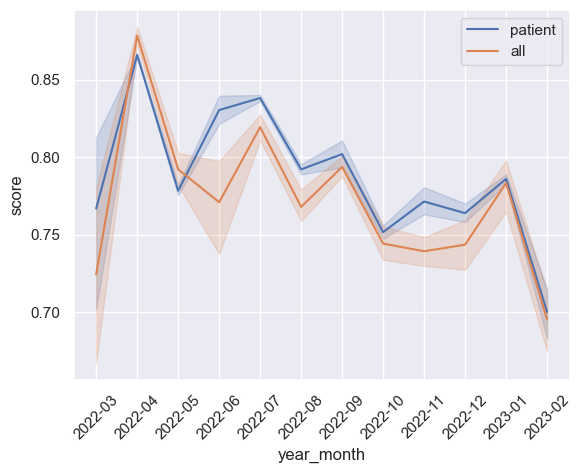

In [25]:
sns.lineplot(data=df_result_all_new[df_result_all_new['features'] == 'patient'], x='year_month', y='score', label='patient')
sns.lineplot(data=df_result_all_new[df_result_all_new['features'] == 'all'], x='year_month', y='score', label='all')
plt.xticks(rotation=45)
plt.show()

In [26]:
df_result_all_new[df_result_all_new['year_month'] == '2022-04']

,structure,year_month,fold,split,features,score,train_name
20,LR,2022-04,0,testmonthvalrandom,all,0.896497,v11_all_testmonthvalrandom_20230327_180848_202...
21,LR,2022-04,1,testmonthvalrandom,all,0.895927,v11_all_testmonthvalrandom_20230327_180848_202...
22,LR,2022-04,2,testmonthvalrandom,all,0.896375,v11_all_testmonthvalrandom_20230327_180848_202...
23,LR,2022-04,3,testmonthvalrandom,all,0.896279,v11_all_testmonthvalrandom_20230327_180848_202...
24,LR,2022-04,4,testmonthvalrandom,all,0.895859,v11_all_testmonthvalrandom_20230327_180848_202...
...,...,...,...,...,...,...,...
755,TabNet,2022-04,0,testmonthvalrandom,si6,0.657326,v11_si6_testmonthvalrandom_20230328_200949_202...
756,TabNet,2022-04,1,testmonthvalrandom,si6,0.659647,v11_si6_testmonthvalrandom_20230328_200949_202...
757,TabNet,2022-04,2,testmonthvalrandom,si6,0.560291,v11_si6_testmonthvalrandom_20230328_200949_202...
758,TabNet,2022-04,3,testmonthvalrandom,si6,0.530708,v11_si6_testmonthvalrandom_20230328_200949_202...


In [126]:

# df_plot1 = reformat_target_table(df_result_all, 'LGBM', 'patient')
# sns.lineplot(data=df_plot1, x='year_month', y='score')
# df_plot2 = reformat_target_table(df_result_all, 'LGBM', 'all')
# sns.lineplot(data=df_plot2, x='year_month', y='score')
# plt.ylim(0.5, 0.95)
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

# T-test

In [20]:
for key, values in v3_12_performance.items():

    v3_12_values = values
    v3_1_values = v3_1_performance[key]
    
    # Perform the paired t-test
    stat, p = ttest_rel(v3_12_values, v3_1_values)

    # Print the results
    print(f"{key}, Paired t-test:")
    print(f" - Statistic: {stat:.4f}")
    print(f" - p-value: {p:.4f}")
    print()

RL, Paired t-test:
 - Statistic: 5.9632
 - p-value: 0.0010

XGBoost, Paired t-test:
 - Statistic: 5.5913
 - p-value: 0.0014

LGBM, Paired t-test:
 - Statistic: 5.5061
 - p-value: 0.0015

TabNet, Paired t-test:
 - Statistic: 3.9345
 - p-value: 0.0077



In [3]:
# Define the dictionary of values
RL_values = {0: 0.838625043318763, 1: 0.8381056968241842, 2: 0.838121731946367, 3: 0.8381724699449158, 4: 0.8386626181573107}

# Assign the values to a list variable
RL_list = [RL_values[i] for i in range(len(RL_values))]

# Print the list variable
print(RL_list)

[0.838625043318763, 0.8381056968241842, 0.838121731946367, 0.8381724699449158, 0.8386626181573107]


In [4]:
from scipy.stats import ttest_rel

# Define the RL performance in the first table and the second table as lists
v3_12_RL = [0.8418617324532305, 0.8415487608796515, 0.8416251735299258, 0.8412595824666369, 0.8419745211855217]
v3_1_RL = [0.838625043318763, 0.8381056968241842, 0.838121731946367, 0.8381724699449158, 0.8386626181573107]

# Perform the paired t-test
stat, p = ttest_rel(table1_RL, table2_RL)

# Print the results
print("Paired t-test:")
print(f"Statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

Paired t-test:
Statistic: 6.9994
p-value: 0.0022
